In [1]:
# !pip install nilearn
# !pip install tikreg

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import re
import csv
import os
import pickle
import glob

# for scientific computing and data visualization 
import numpy as np
import pandas as pd
from scipy import signal
from scipy.stats import zscore, pearsonr
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# for natural language processing
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
# nltk.download('punkt') # Download package punkt if you don't have

# for machine learning
from sklearn.linear_model import Ridge

# for handling neuroimaging data
import nibabel as nib
from nilearn.plotting import view_img, view_img_on_surf

#
from tikreg import models
from sklearn.linear_model import Ridge

/usr/local/anaconda3/envs/sampark/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
base_dirctory = '/Users/clmnlab/Downloads/Paranoia'

In [3]:
glove_model = {}
with open(os.path.join(base_dirctory, 'glove.6B.300d.txt'), 'r', encoding='utf-8') as glove_file:
    for line in glove_file:
        split_line = line.split()
        glove_model[split_line[0]] = np.array([float(x) for x in split_line[1:]])

In [4]:
word_list = []
word_onset = []
word_embedding = np.zeros((0,300))
error_keys = []
with open(os.path.join(base_dirctory,'paranoia_stimuli.txt'), 'r', encoding='utf-8') as stimuli_file:
    stimuli = csv.reader(stimuli_file, delimiter="\t")
    for line in stimuli:
        onset = line[0]
        word = line[2]
        #print(onset, word)
        try:   # Check if the word can be projected
            word_embedding = np.vstack((word_embedding, glove_model[word]))
            word_list.append(word)
            word_onset.append(onset)
        except KeyError:  
            split_word = word_tokenize(word)
            print('Trying to split... ', word, '\t-> ', ' + '.join(split_word))
            try:
                word_vector = np.sum([glove_model[w] for w in split_word], axis=0)
                word_embedding = np.vstack((word_embedding, word_vector))
                word_list.append(word)
                word_onset.append(onset)
            except KeyError:
                error_keys.append(word) # Ignored words     
word_onset = np.array(word_onset, dtype=np.float64)                
print(' ')
print('------------------Error keys(cannot be embedded)-----------------')
print(set(error_keys))


Trying to split...  torson 	->  torson
Trying to split...  torson 	->  torson
Trying to split...  carmen's 	->  carmen + 's
Trying to split...  didn't 	->  did + n't
Trying to split...  wasn't 	->  was + n't
Trying to split...  torson 	->  torson
Trying to split...  torson 	->  torson
Trying to split...  united states 	->  united + states
Trying to split...  torson 	->  torson
Trying to split...  carmen's 	->  carmen + 's
Trying to split...  carmen's 	->  carmen + 's
Trying to split...  flipflops 	->  flipflops
Trying to split...  i'm 	->  i + 'm
Trying to split...  batched 	->  batched
Trying to split...  she'd 	->  she + 'd
Trying to split...  didn't 	->  did + n't
Trying to split...  that's 	->  that + 's
Trying to split...  torson 	->  torson
Trying to split...  wellstocked 	->  wellstocked
Trying to split...  tarson 	->  tarson
Trying to split...  that's 	->  that + 's
Trying to split...  carmen's 	->  carmen + 's
Trying to split...  didn't 	->  did + n't
Trying to split...  carme

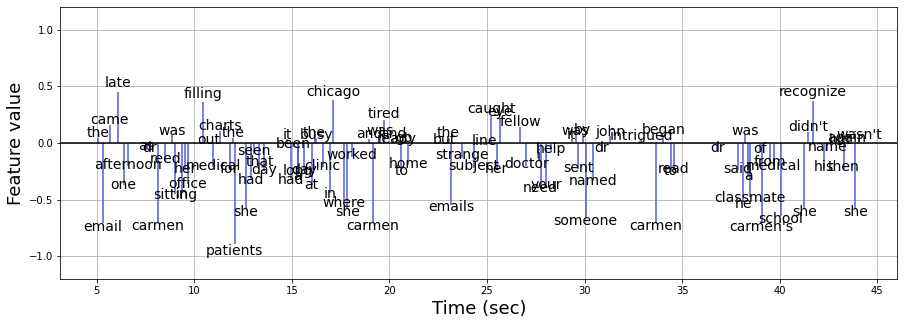

In [5]:
n_words = 100   # first 100 words
feature = 0    # first feature

plt.figure(figsize=(15,5))
plt.axhline(0, c='k')
plt.vlines(word_onset[:n_words], [0], 
           word_embedding[:n_words, feature], color='#4f5bd5', label='word vectors')
# The blue peak represents each word

for i in range(n_words):
    plt.text(word_onset[i], 1.1*word_embedding[i, feature], 
             s=word_list[i], ha='center', fontsize=14)

plt.xlabel('Time (sec)', fontsize=18)
plt.ylabel('Feature value', fontsize=18)
plt.grid()
plt.ylim(-1.2, 1.2)
plt.show()

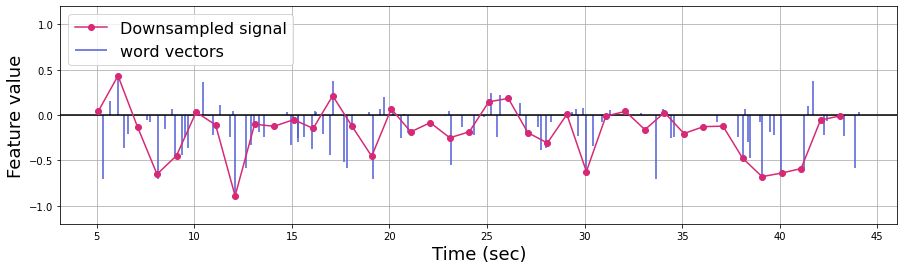

In [6]:
plt.figure(figsize=(15,4))
plt.axhline(0, c='k')
plt.vlines(word_onset[:n_words], [0], 
           word_embedding[:n_words, feature], color='#4f5bd5', label='word vectors')
# Linear interpolation
linear_downsample = interp1d(word_onset[:n_words], 
                             word_embedding[:n_words, feature], kind='linear')

TR_time = np.arange(np.min(word_onset[:n_words]), np.max(word_onset[:n_words])) # Specify the number of time points
downsampled_vector = linear_downsample(TR_time)

plt.plot(TR_time, downsampled_vector, 'o-',color='#d62976', label='Downsampled signal')

plt.legend(loc='upper left', fontsize=16)
plt.xlabel('Time (sec)', fontsize=18)
plt.ylabel('Feature value', fontsize=18)
plt.grid()
plt.ylim(-1.2, 1.2)
plt.show()

In [7]:
word_embedding_downsample = []
TR_time = np.arange(np.min(word_onset), np.max(word_onset))
for feature in range(300):
    linear_downsample = interp1d(word_onset, 
                                word_embedding[:, feature], kind='linear')

    TR_time = np.arange(np.min(word_onset), np.max(word_onset))
    downsampled_vector = linear_downsample(TR_time)
    downsampled_vector = np.concatenate([np.zeros(5), downsampled_vector, np.zeros(2)])
    word_embedding_downsample.append(downsampled_vector)

word_embedding_downsample = np.array(word_embedding_downsample).T
print('Original stimuli: ', word_embedding.shape)
print('Downsampled stimuli: ', word_embedding_downsample.shape)

Original stimuli:  (3440, 300)
Downsampled stimuli:  (1310, 300)


/usr/local/anaconda3/envs/sampark/lib/python3.7/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "



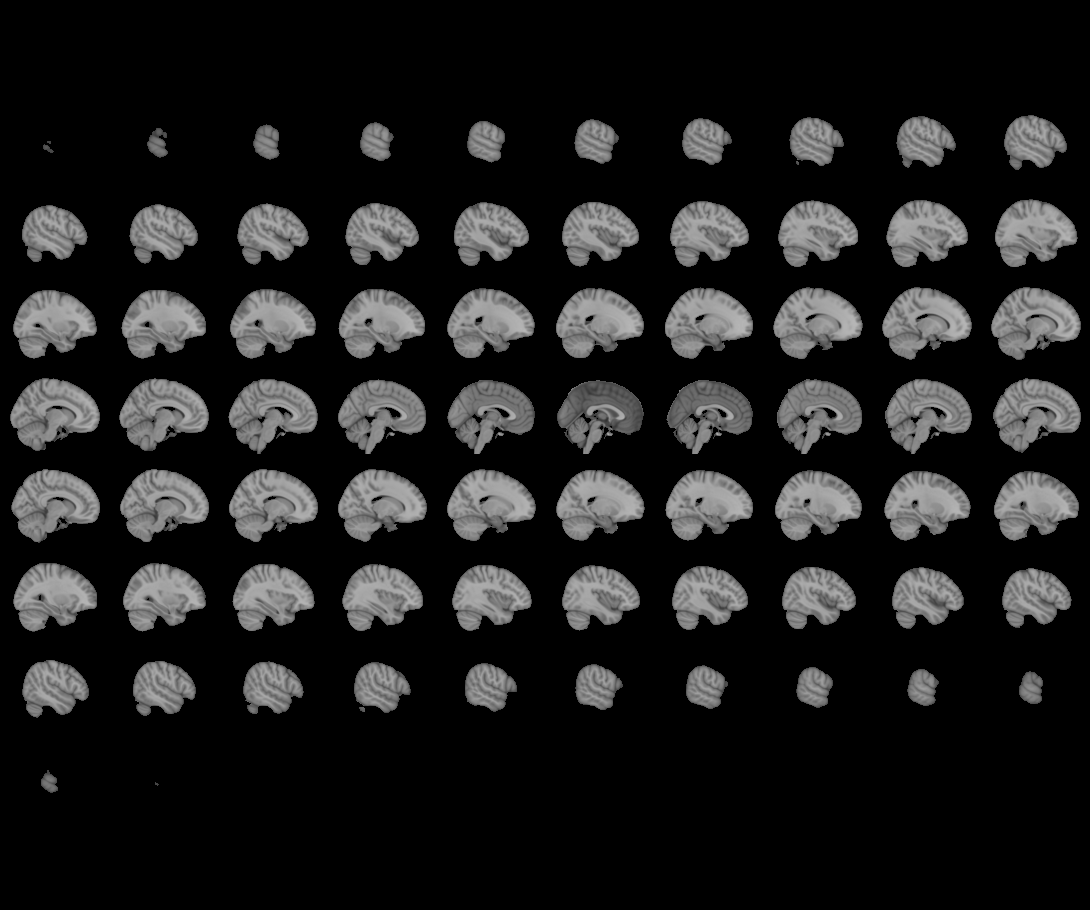
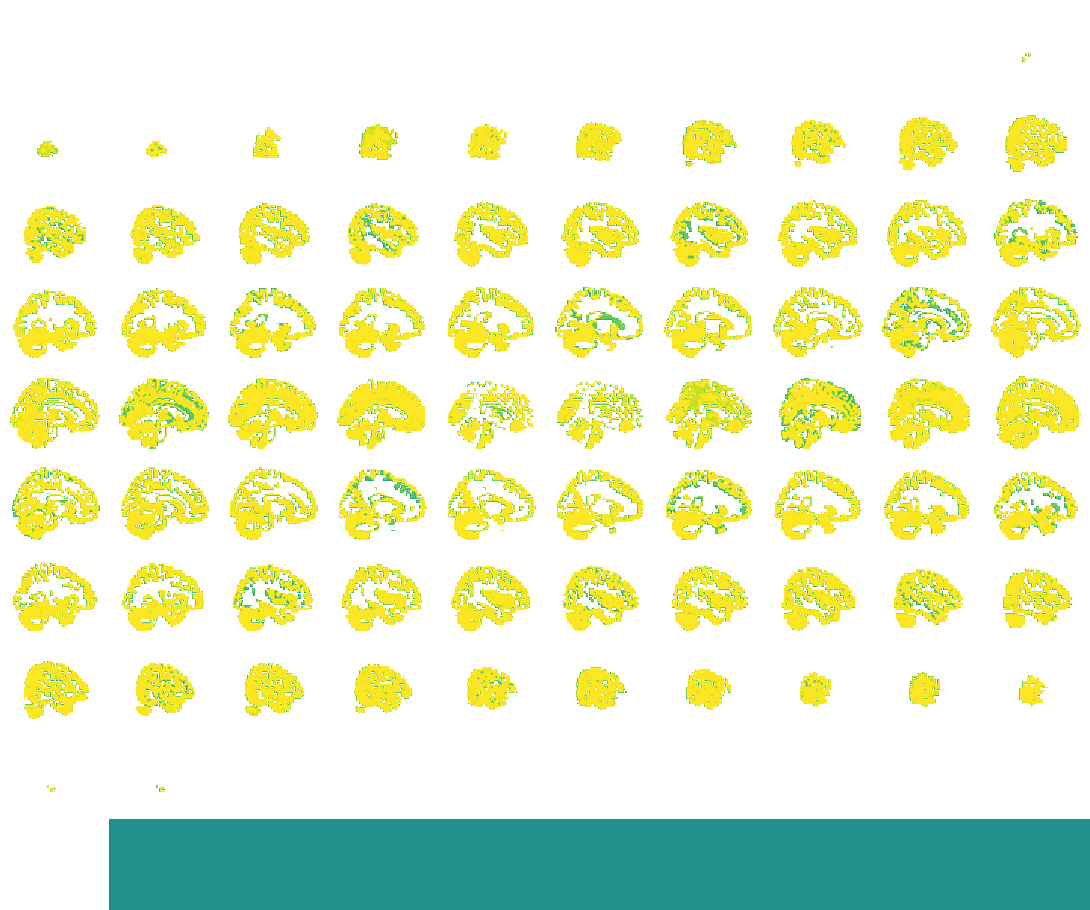

In [8]:
mask_img = nib.load(os.path.join(base_dirctory, 'brain_mask_3mm.nii'))
mask_data = mask_img.get_fdata()

view_img(mask_img, cmap='viridis')

In [9]:
np.unique(mask_data)

array([0., 1.])

In [10]:
fmri_data = nib.load(os.path.join(base_dirctory, 'sub-tb2994_3mm.nii.gz')).get_fdata()
print(fmri_data.shape)

fmri_data_masked = fmri_data[mask_data==1].T
print(fmri_data_masked.shape)


(65, 77, 65, 1310)
(1310, 51206)


In [11]:
def make_delayed(stim, delays, circpad=False):
    # from  https://github.com/HuthLab/speechmodeltutorial
    nt,ndim = stim.shape
    dstims = []
    for di,d in enumerate(delays):
        dstim = np.zeros((nt, ndim))
        if d<0: ## negative delay
            dstim[:d,:] = stim[-d:,:]
            if circpad:
                dstim[d:,:] = stim[:-d,:]
        elif d>0:
            dstim[d:,:] = stim[:-d,:]
            if circpad:
                dstim[:d,:] = stim[-d:,:]
        else: ## d==0
            dstim = stim.copy()
        dstims.append(dstim)
    return np.hstack(dstims)



# Split data into train and test dataset 
train_timepoints = 1100
X_train = word_embedding_downsample[:train_timepoints,:]
X_test = word_embedding_downsample[train_timepoints:, :]

y_train = fmri_data_masked[:train_timepoints,:]
y_test = fmri_data_masked[train_timepoints:, :]

# Normalize and remove NaNs
X_train = zscore(X_train, axis=0)
X_train = np.nan_to_num(X_train)
X_test = zscore(X_test, axis=0)
X_test = np.nan_to_num(X_test)

y_train = zscore(y_train, axis=0)
y_train = np.nan_to_num(y_train)
y_test = zscore(y_test, axis=0)
y_test = np.nan_to_num(y_test)

print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)
print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape)

# Apply delayer (FIR model)
X_train = make_delayed(X_train, [4,6,8])
X_test = make_delayed(X_test, [4,6,8])

print('X_train (delayed): ', X_train.shape)
print('X_test (delayed): ', X_test.shape)

X_train:  (1100, 300)
X_test:  (210, 300)
y_train:  (1100, 51206)
y_test:  (210, 51206)
X_train (delayed):  (1100, 900)
X_test (delayed):  (210, 900)


In [12]:
model_type = 'ridge_cv' # 'ridge' or 'ridge_cv'

if model_type == 'ridge_cv':
    # Model is automatically fit using kernel ridge
    fit = models.cvridge(X_train, y_train, X_test, y_test,
                        ridges=np.logspace(0,3,11), weights=True, metric='rsquared')

    # The weights are in the feature space
    weights_estimate = fit['weights']
    print(weights_estimate.shape)  # (nfeatures, nresponses)

    y_pred = np.dot(X_test, weights_estimate)
elif model_type == 'ridge':

    reg = Ridge(alpha=200) 
    reg.fit(X_train, y_train)

    y_pred = reg.predict(X_test)

n_vox = y_pred.shape[1]
voxcorrs = np.array([pearsonr(y_test[:, vox], y_pred[:,vox])[0] for vox in range(n_vox)])
voxcorrs = np.nan_to_num(voxcorrs)
print(voxcorrs.shape)

Fitting *11* ridges, across *5* folds, and *1* "linear" kernel parameters
Caching *linear* kernel
Updating *linear* kernel 1/1:None
train ridge fold  1/5: ntrain=880, nval=220
lambda 01:    1.000, mean=-5.7304, (25,50,75)pctl=(-6.5290,-5.8066,-5.1364),(0.0<r>0.5): (000,000)
lambda 02:    1.995, mean=-3.2278, (25,50,75)pctl=(-3.6734,-3.2786,-2.9024),(0.0<r>0.5): (000,000)
lambda 03:    3.981, mean=-1.7207, (25,50,75)pctl=(-1.9657,-1.7497,-1.5378),(0.0<r>0.5): (000,000)
lambda 04:    7.943, mean=-0.8298, (25,50,75)pctl=(-0.9639,-0.8439,-0.7245),(0.0<r>0.5): (000,000)
lambda 05:   15.849, mean=-0.3544, (25,50,75)pctl=(-0.4292,-0.3598,-0.2898),(0.0<r>0.5): (001,000)
lambda 06:   31.623, mean=-0.1251, (25,50,75)pctl=(-0.1653,-0.1261,-0.0864),(0.0<r>0.5): (578,000)
lambda 07:   63.096, mean=-0.0308, (25,50,75)pctl=(-0.0506,-0.0311,-0.0106),(0.0<r>0.5): (6721,000)
lambda 08:  125.893, mean=-0.0035, (25,50,75)pctl=(-0.0120,-0.0038,0.0037),(0.0<r>0.5): (18018,000)
lambda 09:  251.189, mean=0.00

/usr/local/anaconda3/envs/sampark/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(51206,)


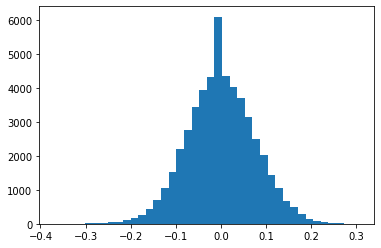

In [13]:
voxcorrs = np.nan_to_num(voxcorrs)
plt.hist(voxcorrs, bins=40)
plt.show()

4696


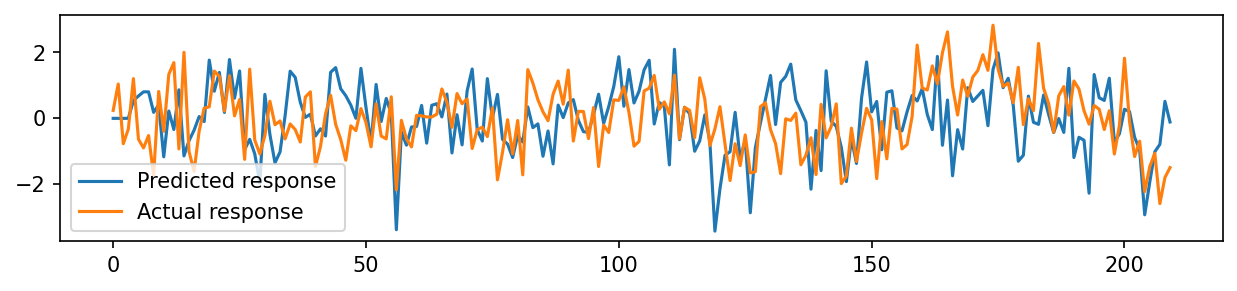

In [14]:
best_voxel = np.argmax(voxcorrs)
print(best_voxel)

plt.figure(figsize=(10,2), dpi=150)
plt.plot(zscore(y_pred[:,best_voxel]), label='Predicted response')
plt.plot(zscore(y_test[:,best_voxel]), label='Actual response')
plt.legend()
plt.show()


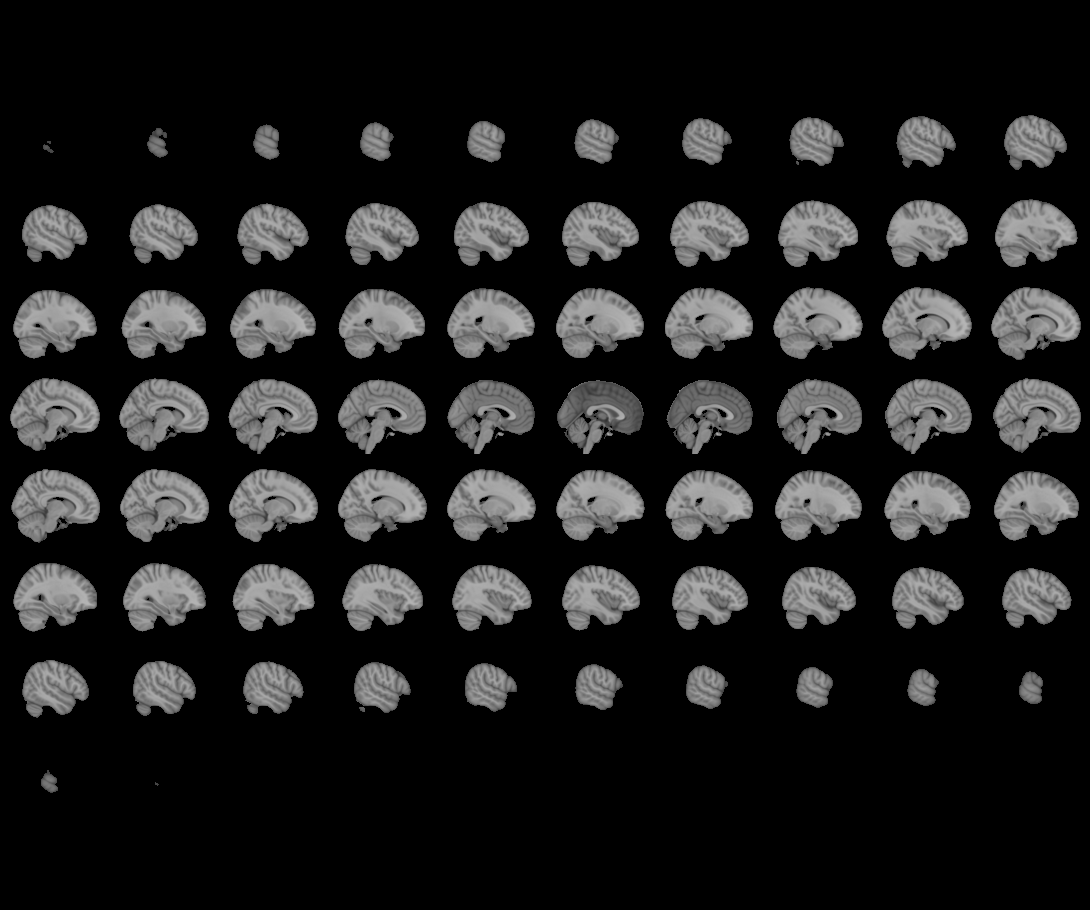
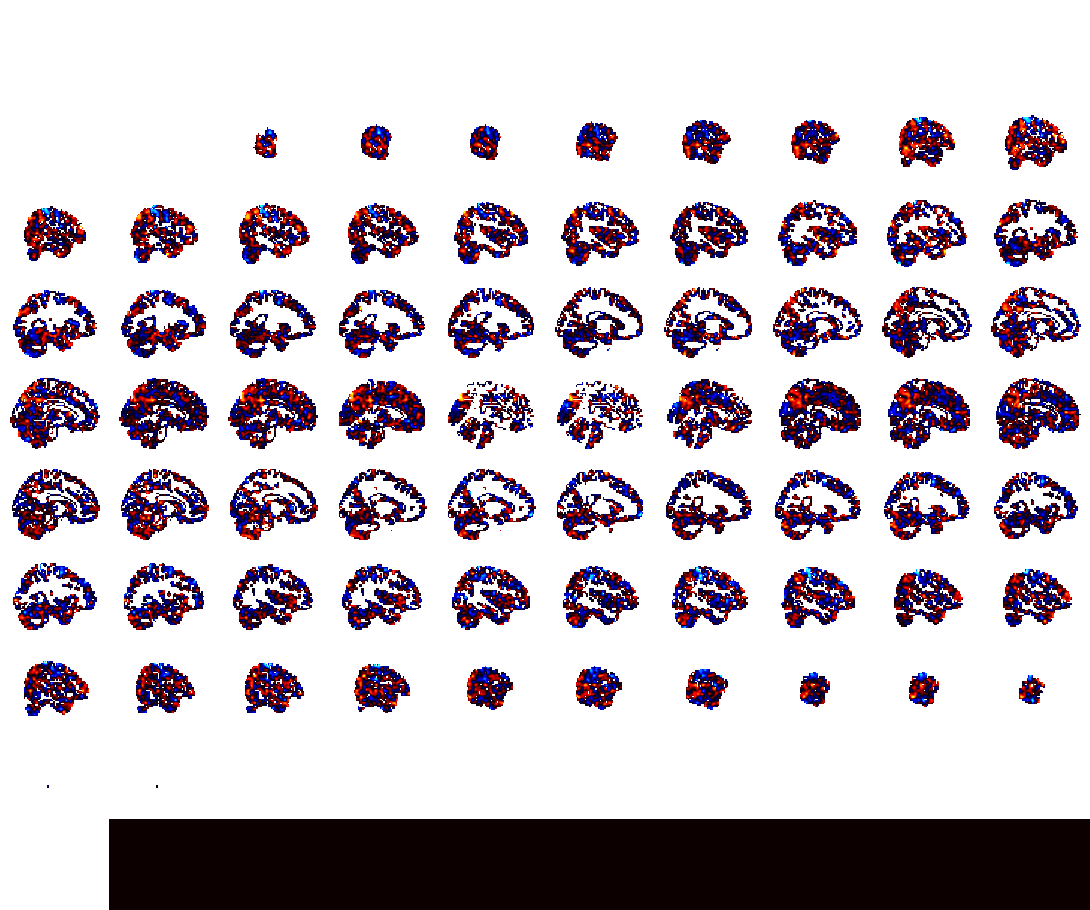

In [15]:
statmap = np.zeros(mask_data.shape)
statmap[mask_data==1] = voxcorrs

statmap_img = nib.Nifti1Image(statmap, mask_img.affine)

view_img(statmap_img)

In [16]:
view_img_on_surf(statmap_img)